In [50]:
from tqdm import tqdm
import os
from datetime import datetime
from time import time
import pandas as pd
from src.datasets import TextConcatFactCheck, TextConcatPosts
from src.models import EmbeddingModel, BaseModel
from src import config
from src.utils import log_info
import spacy
from tqdm import tqdm
import numpy as np
tqdm.pandas()

class IEModel(BaseModel):
    '''
    This model receives:
        - Fact-check claims dataset with a column called full_text
        - Spacy model name
    
    Applies Spacy NER to the full_text column and stores the entities in a set.
    Applies lemmatisation to the full_text column and stores the lemmas in a set.
    
    Compares the entities and lemmas of the fact-check claims with the entities and lemmas of the posts.
    Take the k first fact check for each post with the highest number of common entities and lemmas.
    '''
    
    def __init__(self, model_name, df_fc, device="cuda",  k=10, batch_size=512, **kwargs):
        # "en_core_web_sm"
        if device == "cuda":
            spacy.prefer_gpu()
            
        self.model = spacy.load(model_name)
        # self.idx_to_text = df_fc["full_text"].to_dict()
        self.pos_to_idx = dict(enumerate(df_fc.index))
        self.vectorized_map = np.vectorize(lambda x: self.pos_to_idx.get(x, None))                
        super().__init__(device, k=k, batch_size=batch_size)
        if k is None:
            self.k = len(df_fc)
        self.emb_fc = self.encode(df_fc["full_text"].values)

    
    def encode(self, texts):
        processed = [self.process_text(doc) for doc in self.model.pipe(texts, batch_size=self.batch_size)]
        return processed

    def train(self, texts):
        pass

    def predict(self, texts, debug=False):
        # emb_texts = self.encode(texts)#.values  # Convert to a list or numpy array for faster iteration
        # fc_texts = self.emb_fc#.values

        # # Calculate intersections efficiently
        # preds = []
        # for emb in emb_texts:
        #     common_counts = np.array([len(emb & fc_el) for fc_el in fc_texts])
        #     top_k_indices = np.argsort(-common_counts)[:self.k]  # Sort and pick top k indices
        #     preds.append([self.pos_to_idx[i] for i in top_k_indices])
        
        ls_lemmas = self.emb_fc
        set_ls_lemmas = [set(y) for y in ls_lemmas]

        text_emb = self.encode(texts)
        ls_intersec = [[set(x).intersection(y) for y in set_ls_lemmas] for x in text_emb]
        len_intersec = [[len(x) for x in y] for y in ls_intersec]
        # top_nonzero = [self.non_zero_in_top(np.array(x), k=self.k) for x in ls_intersec]
        top_nonzero = [np.argsort(-np.array(x))[:self.k] for x in len_intersec]
        preds = [[self.pos_to_idx[i] for i in x] for x in top_nonzero]
        if debug:
            return preds, len_intersec, ls_intersec, top_nonzero
        else:
            return preds

    @staticmethod
    def non_zero_in_top(arr, k=None):
        # get the indices of the top nonzero elements
        if k is None:
            k = len(arr)
        top = np.argsort(-arr)[:k]
        non_zero = np.nonzero(arr)[0]
        # get the nonzero elements in top preserving the order of top
        non_zero_in_top = [x for x in top if x in non_zero]
        return non_zero_in_top
    
    @staticmethod
    def process_text(doc):
        # Extract lemmatized tokens (including named entities), excluding punctuation and stopwords and spaces
        return [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and not token.is_space]

In [2]:

task_name = "monolingual"
langs = ["eng"]
lang = "ara"
output_path = None
model_name = '/home/bsc/bsc830651/.cache/huggingface/hub/models--intfloat--multilingual-e5-large/snapshots/ab10c1a7f42e74530fe7ae5be82e6d4f11a719eb'
tasks_path = config.TASKS_PATH
posts_path = config.POSTS_PATH
fact_checks_path = config.FACT_CHECKS_PATH

"""
Run the task with the given parameters.
"""
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

if output_path is not None:
    output_path = os.path.join(output_path, task_name, current_time)

# langs = ["eng"] if task_name == "crosslingual" else langs

log_info(f"Task: {task_name}")
log_info(f"Tasks path: {tasks_path}")
# log_info(f"Languages: {langs}")
log_info(f"Model: {model_name}")
log_info(f"Output path: {output_path}\n")

# Paths from config
posts_path = config.POSTS_PATH
fact_checks_path = config.FACT_CHECKS_PATH
gs_path = config.GS_PATH

# tasks_path = "data/splits/tasks_local_dev.json"
ls_k = [1, 3, 5, 10]

d_out = {}
df_eval = pd.DataFrame(index=ls_k)
df_eval.index.name = "k"

# for lang in tqdm(langs, desc="Languages"):

log_info(f"Lang: {lang}")
time_start_lang = time()

log_info("Loading posts...")
time_start = time()
# posts = TextConcatPosts(posts_path, tasks_path, task_name=task_name, gs_path=gs_path, lang=lang, clean=True)
posts_en = TextConcatPosts(posts_path, tasks_path, task_name=task_name, gs_path=gs_path, lang=lang, version="english", clean=True)

# log_info(f"Loaded {len(posts)}")
log_info(f"Time taken: {time() - time_start:.2f}s\n")

# log_info("Loading fact checks..")
# time_start = time()
# fact_checks = TextConcatFactCheck(fact_checks_path, tasks_path, task_name=task_name, lang=lang, clean=True)
fact_checks_en = TextConcatFactCheck(fact_checks_path, tasks_path, task_name=task_name, lang=lang, version="english", clean=True)

# log_info(f"Loaded {len(fact_checks)}")
# log_info(f"Time taken: {time() - time_start:.2f}s\n")

# df_posts_train = posts.df_train
df_posts_train_en = posts_en.df_train

# df_fc = fact_checks.df
df_fc = fact_checks_en.df

# df_posts_dev = posts.df_dev
# df_posts_dev_en = posts_en.df_dev


# nlp = spacy.load("en_core_web_sm")

# df_posts_train["lemmas"] = df_posts_train_en["full_text"].progress_apply(lambda x: [y.lemma_ for y in nlp(x) if y.is_stop == False and y.is_punct == False and y.is_space == False and y.is_alpha == True])
# df_posts_train["entities"] = df_posts_train_en["full_text"].progress_apply(extract_entities)
# df_posts_train["entities_lemmas"] = df_posts_train["entities"] + df_posts_train["lemmas"]

# # df_posts_dev["lemmas"] = df_posts_dev["full_text"].progress_apply(lambda x: [y.lemma_ for y in nlp(x) if y.is_stop == False and y.is_punct == False and y.is_space == False and y.is_alpha == True])
# # df_posts_dev["entities"] = df_posts_dev["full_text"].progress_apply(extract_entities)

# df_fc["lemmas"] = df_fc["full_text"].progress_apply(lambda x: [y.lemma_ for y in nlp(x) if y.is_stop == False and y.is_punct == False and y.is_space == False and y.is_alpha == True])
# df_fc["entities"] = df_fc["full_text"].progress_apply(extract_entities)
# df_fc["entities_lemmas"] = df_fc["entities"] + df_fc["lemmas"]

log_info("Loading model...")
# time_start = time()
# model = EmbeddingModel(model_name, df_fc, batch_size=512)
# log_info(f"Time taken: {time() - time_start:.2f}s\n")

2024-11-02 16:02:57,661 - INFO - Task: monolingual
2024-11-02 16:02:57,661 - INFO - Tasks path: data/splits/tasks_no_gs_overlap.json
2024-11-02 16:02:57,662 - INFO - Model: /home/bsc/bsc830651/.cache/huggingface/hub/models--intfloat--multilingual-e5-large/snapshots/ab10c1a7f42e74530fe7ae5be82e6d4f11a719eb
2024-11-02 16:02:57,662 - INFO - Output path: None

2024-11-02 16:02:57,663 - INFO - Lang: ara
2024-11-02 16:02:57,663 - INFO - Loading posts...
2024-11-02 16:03:00,309 - INFO - Time taken: 2.65s

2024-11-02 16:03:03,064 - INFO - Loading model...


In [51]:
ie_model = IEModel("en_core_web_trf", df_fc, batch_size=512, k=None)

/home/bsc/bsc830651/.conda/envs/factcheck/lib/python3.10/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.

In [52]:
df_posts_train_en_proc = df_posts_train_en.copy().sample(50, random_state=42)
preds, len_intersec, ls_intersec, top_nonzero = ie_model.predict(df_posts_train_en_proc["full_text"].values, debug=True)
df_posts_train_en_proc["preds"] = preds

In [55]:
ie_model.evaluate(df_posts_train_en_proc,task_name="monolingual", lang=lang)

{'monolingual': {'ara': {1: 0.52, 3: 0.68, 5: 0.68, 10: 0.72}}}

In [49]:
ie_model.emb_fc

[['fact',
  'Sisi',
  'drink',
  'mineral',
  'water',
  'import',
  'France',
  'drink',
  'import',
  'mineral',
  'water',
  'evian',
  'boy',
  'okay',
  'army',
  'water',
  'pure',
  'austerity',
  'half',
  'confuse',
  'movie',
  'dialogue',
  'people',
  'price',
  'french',
  'evian',
  'water',
  'import',
  'month',
  'home',
  'half',
  'salary',
  'definitely',
  'depend',
  'form'],
 ['video',
  'New',
  'Zealand',
  'police',
  'manage',
  'kill',
  'perpetrator',
  'terrorist',
  'attack',
  'misleading',
  'title',
  'Police',
  'manage',
  'reach',
  'kill',
  'New',
  'Zealand',
  'mosque',
  'attacker'],
 ['judo',
  'player',
  'Muhammad',
  'Rashwan',
  'deliberately',
  'lose',
  'Japanese',
  '3000',
  'Japanese',
  'convert',
  'Islam',
  'truth',
  'Mohamed',
  'Rashwan',
  'reason',
  'fame',
  '1984',
  'Los',
  'Angeles',
  'Olympics',
  'Mohamed',
  'Rashwan',
  'reach',
  'final',
  'japanese',
  'world',
  'champion',
  'Egyptian',
  'Mohamed',
  'Rashwa

In [48]:
[x for x in ls_intersec[0] if len(x) > 0]

[{'o'},
 {'o'},
 {'d', 'j', 's'},
 {'o'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'b', 't'},
 {'C'},
 {'o'},
 {'t'},
 {'C'},
 {'d', 'j', 's'},
 {'O'},
 {'c'},
 {'B'},
 {'d', 'j', 's'},
 {'o'},
 {'o'},
 {'d', 'j', 'o', 's'},
 {'o'},
 {'O'},
 {'o'},
 {'e'},
 {'d', 'j', 's'},
 {'e'},
 {'g'},
 {'t'},
 {'o'},
 {'d', 'j', 's'},
 {'o'},
 {'s'},
 {'d', 'j', 's'},
 {'t'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'m'},
 {'o'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'o'},
 {'o'},
 {'t'},
 {'o'},
 {'d', 'j', 's'},
 {'o'},
 {'d', 'j', 's'},
 {'t'},
 {'d', 'j', 's'},
 {'e'},
 {'g'},
 {'d', 'j', 'o', 's'},
 {'d', 'j', 's'},
 {'o'},
 {'C'},
 {'k'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'t'},
 {'d', 'j', 's'},
 {'g'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'t'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'O'},
 {'o'},
 {'o'},
 {'d', 'j', 's'},
 {'d', 'j', 's'},
 {'m'},
 {'

In [64]:
ls_intersec[1][10487]

3

In [54]:
top_nonzero

[array([  663, 10487,  3180, ..., 14199, 14200,     0]),
 array([  663,  3180, 10487, ..., 14199, 14200,     0]),
 array([  663, 10487,  3180, ..., 14199, 14200,     0]),
 array([  663, 10487,  3180, ..., 14199, 14200,     0]),
 array([  663, 12825,  3180, ..., 14199, 14200,     0]),
 array([  663, 10487,  3180, ..., 14199, 14200,     0]),
 array([  663,  3180, 10487, ..., 14199, 14200,     0]),
 array([ 1457, 12825, 10487, ..., 14199, 14200,     0]),
 array([ 3180,   663, 10487, ..., 14199, 14200,     0]),
 array([12825,  3180,   663, ..., 14199, 14200,     0])]

In [15]:
df_posts_train_en_proc["preds"].iloc[0].index(df_posts_train_en_proc["gs"].iloc[0][0])

469

In [19]:
idx_to_pos = {v: k for k, v in ie_model.pos_to_idx.items()}

In [27]:
ls_intersec

0

In [29]:
gs = df_posts_train_en_proc["gs"].iloc[0][0]
ls_preds = df_posts_train_en_proc["preds"].iloc[0]
ls_intersec_0 = ls_intersec[0]
ls_intersec_0[idx_to_pos[gs]]

0

In [32]:
df_posts_train_en_proc["full_text"].iloc[0]

' Hurricane Shaheen, which struck Oman, was filmed from the Burj Khalifa in Dubai. See the greatness of the Creator!!!'

In [34]:
df_fc["full_text"].loc[163304]

'This video is digitally created and not real scenes from Hurricane Shaheen Hurricane Shaheen, which struck Oman, was filmed from the Burj Khalifa in Dubai. See the greatness of the Creator'

In [35]:
df_fc

,claim,instances,title,full_text
fact_check_id,,,,
12,"!! He drinks imported mineral water, Evian boy...",[https://dabegad.com/%d8%ad%d9%82%d9%8a%d9%82%...,The fact that Sisi drank mineral water importe...,The fact that Sisi drank mineral water importe...
18,"""Police managed to reach him and kill the New ...",[https://fatabyyano.net/%d8%a7%d9%84%d8%b4%d8%...,(Video) New Zealand police managed to kill the...,(Video) New Zealand police managed to kill the...
19,"""Mohamed Rashwan"" The reason for his fame is d...",[https://fatabyyano.net/%d9%85%d8%ad%d9%85%d8%...,Judo player Muhammad Rashwan deliberately lost...,Judo player Muhammad Rashwan deliberately lost...
20,"""New Zealand..By the grace of God Almighty, th...",[https://fatabyyano.net/%d9%85%d8%b3%d8%ac%d8%...,Al Noor Mosque in New Zealand receives multipl...,Al Noor Mosque in New Zealand receives multipl...
21,Important: It is not preferable to take antipy...,[https://fatabyyano.net/%d8%a7%d9%84%d8%a5%d9%...,Ibuprofen increases the spread of corona and n...,Ibuprofen increases the spread of corona and n...
...,...,...,...,...
205735,An Algerian woman is crying alone at the airpo...,[https://misbar.com/factcheck/2020/11/14/عراقي...,,An Algerian woman is crying alone at the airp...
205736,An American policeman insults Prince Sultan bi...,[https://dabegad.com/%d8%ad%d9%82%d9%8a%d9%82%...,The truth of a video of an American policeman ...,The truth of a video of an American policeman ...
205737,Western scholars discovered an animal that did...,[https://dabegad.com/%d8%ad%d9%82%d9%8a%d9%82%...,The fact that the kangaroo mouse dies if he dr...,The fact that the kangaroo mouse dies if he dr...


In [33]:
df_posts_train_en_proc

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,preds
post_id,,,,,,,,,,
22840,,Altered video,"Hurricane Shaheen, which struck Oman, was film...",ara,1,0,0,"Hurricane Shaheen, which struck Oman, was fil...",[163304],"[163492, 166030, 173531, 176591, 163348, 17655..."
23096,,False information,Brazilians hang an official on a pole to prote...,ara,1,0,0,Brazilians hang an official on a pole to prot...,[166428],"[163492, 166030, 173531, 193833, 164655, 16424..."
3941,,,#Do you know Why is it forbidden to fly over t...,ara,0,0,1,#Do you know Why is it forbidden to fly over ...,[165665],"[166030, 173531, 163492, 176766, 8371, 164655,..."
27547,,Missing context,🔺 While the Polisario and Algeria are still re...,ara,1,0,0,While the Polisario and Algeria are still re...,[171924],"[166030, 163492, 173531, 193833, 164748, 17676..."
23193,,False information,John Biden bows to a brown child from South Su...,ara,1,0,0,John Biden bows to a brown child from South S...,[167519],"[163492, 173531, 166030, 176591, 163457, 16474..."
22973,Tripoli worldwide airport TIP,,The final image of Tripoli International Airpo...,ara,1,0,0,Tripoli worldwide airport TIP The final image ...,[165241],"[163492, 166030, 173531, 8540, 193833, 163457,..."
23611,,False information,from Al mansora : When a mother prefers to die...,ara,1,0,0,from Al mansora : When a mother prefers to di...,[165390],"[163492, 173531, 166030, 193833, 164243, 17655..."
23299,Bill Tik Tok [USER],,"A fish risks its life to save another fish, th...",ara,1,0,0,Bill Tik Tok [USER] A fish risks its life to s...,[168753],"[163492, 165962, 166030, 173531, 163348, 7749,..."
27184,There is no might nor power except with God 9 ...,Missing Context,💔💔💔💔💔,other,0,0,1,There is no might nor power except with God 9 ...,[170087],"[163492, 166030, 173531, 176766, 164243, 16474..."


In [12]:
df_posts_train_en_proc

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,preds
post_id,,,,,,,,,,
22840,,Altered video,"Hurricane Shaheen, which struck Oman, was film...",ara,1,0,0,"Hurricane Shaheen, which struck Oman, was fil...",[163304],"[163492, 166030, 173531, 176591, 163348, 17655..."
23096,,False information,Brazilians hang an official on a pole to prote...,ara,1,0,0,Brazilians hang an official on a pole to prot...,[166428],"[163492, 166030, 173531, 193833, 164655, 16424..."
3941,,,#Do you know Why is it forbidden to fly over t...,ara,0,0,1,#Do you know Why is it forbidden to fly over ...,[165665],"[166030, 173531, 163492, 176766, 8371, 164655,..."
27547,,Missing context,🔺 While the Polisario and Algeria are still re...,ara,1,0,0,While the Polisario and Algeria are still re...,[171924],"[166030, 163492, 173531, 193833, 164748, 17676..."
23193,,False information,John Biden bows to a brown child from South Su...,ara,1,0,0,John Biden bows to a brown child from South S...,[167519],"[163492, 173531, 166030, 176591, 163457, 16474..."
22973,Tripoli worldwide airport TIP,,The final image of Tripoli International Airpo...,ara,1,0,0,Tripoli worldwide airport TIP The final image ...,[165241],"[163492, 166030, 173531, 8540, 193833, 163457,..."
23611,,False information,from Al mansora : When a mother prefers to die...,ara,1,0,0,from Al mansora : When a mother prefers to di...,[165390],"[163492, 173531, 166030, 193833, 164243, 17655..."
23299,Bill Tik Tok [USER],,"A fish risks its life to save another fish, th...",ara,1,0,0,Bill Tik Tok [USER] A fish risks its life to s...,[168753],"[163492, 165962, 166030, 173531, 163348, 7749,..."
27184,There is no might nor power except with God 9 ...,Missing Context,💔💔💔💔💔,other,0,0,1,There is no might nor power except with God 9 ...,[170087],"[163492, 166030, 173531, 176766, 164243, 16474..."


In [68]:
df_posts_train_en_proc.loc[2512]["full_text"]

'Imam Ahmad Al-Tayeb [USER] Billions are spent on soap operas satiric mint CommentSsaser On the pretext that it represents reality if you spend on The reality is the same for him '

In [67]:
df_fc.loc[169089]["full_text"]

'The tweet attributed to the Sheikh of Al-Azhar about the budgets of the series is fake The Sheikh of Al-Azhar criticizes the financing of soap operas'

In [10]:
ie_model.evaluate(df_posts_train_en_proc,task_name="monolingual", lang=lang, ls_k=[10000])

{'monolingual': {'ara': {10000: 0.76}}}

In [38]:
df_posts_train_en_proc.apply(lambda x: len(set(x["gs"]).intersection(set(x["preds"]))), axis=1)

post_id
2512    1
2513    1
2524    1
2530    1
2532    1
2533    1
2534    1
2536    1
2764    1
3010    1
dtype: int64

In [23]:
ie_model.emb_fc[5]

['$',
 '30',
 'Corona',
 'examination',
 'fee',
 'leave',
 'Rafah',
 'crossing',
 'southern',
 'Gaza',
 'Strip']

In [21]:
df_posts_train_en_proc

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,preds
post_id,,,,,,,,,,
2512,Imam Ahmad Al-Tayeb [USER] Billions are spent ...,False information,,ara,1,0,0,Imam Ahmad Al-Tayeb [USER] Billions are spent ...,[169089],"[163492, 173531, 166030, 176766, 8369, 8370, 1..."
2513,automatic caller The arrival of the robotic pr...,False information,,ara,1,0,0,automatic caller The arrival of the robotic pr...,[167926],"[163492, 166030, 173531, 176591, 8369, 8370, 8..."
2524,Distribution of books on the first day of scho...,,,ara,1,0,0,Distribution of books on the first day of scho...,[167255],"[163492, 173531, 166030, 176766, 163457, 16334..."
2530,A rare photo of the current president of Franc...,,,ara,1,0,0,A rare photo of the current president of Franc...,[171616],"[163492, 173531, 166030, 176591, 163457, 16334..."
2532,"Indeed, love does miracles Ramy is a 20-year-o...",False information,,ara,1,0,0,"Indeed, love does miracles Ramy is a 20-year-o...",[168268],"[163492, 175896, 166030, 173531, 164307, 17609..."
...,...,...,...,...,...,...,...,...,...,...
27736,Speed 1350.. .. ..:: The fastest train in the ...,False information,😳😳😳😳😳🔥🔥🔥👇👇👇👇,other,1,0,0,Speed 1350. . .:: The fastest train in the wor...,[8960],"[175896, 163492, 166030, 173531, 164307, 17609..."
27852,,False information,🚨🚨 Appointment of Major General Doctor Atef in...,ara,1,0,0,Appointment of Major General Doctor Atef in ...,[167086],"[163492, 173531, 166030, 176591, 163457, 16334..."
27853,global master sat Ek SUBSCRIB CANLI ISTANBUL s...,False information,🚨🚨 Urgent: Erdogan: It is time to send forces ...,ara,1,0,0,global master sat Ek SUBSCRIB CANLI ISTANBUL s...,[152569],"[173531, 163492, 166030, 8540, 8370, 176766, 1..."


In [20]:
ie_model.evaluate(df_posts_train_en_proc, task_name=task_name, lang=lang, ls_k=[100000000])

{'monolingual': {'ara': {100000000: 0.01309328968903437}}}

In [15]:
df_posts_train_en_proc["preds"].map(len).value_counts().sort_index(ascending=False)

preds
557    1
505    1
483    1
476    1
471    1
      ..
102    1
83     1
82     1
71     1
44     1
Name: count, Length: 167, dtype: int64

In [25]:
import spacy
import pandas as pd

# Load SpaCy model with GPU support (use the right model name for your domain/language)
spacy.require_gpu()
nlp = spacy.load("en_core_web_trf")  # Transformer model with GPU support

def process_text(doc):
    # Extract lemmatized tokens of named entities, excluding punctuation and stopwords and spaces

    return [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and not token.is_space]

df_posts_train_proc = df_posts_train_en.copy()
df_fc_proc = df_fc.copy()

# Process texts in batches and add results to a new column
df_posts_train_proc["entities_lemmas"] = [process_text(doc) for doc in nlp.pipe(df_posts_train_en["full_text"], batch_size=512)]
df_fc_proc["entities_lemmas"] = [process_text(doc) for doc in nlp.pipe(df_fc["full_text"], batch_size=512)]

print(df_posts_train_proc)


/home/bsc/bsc830651/.conda/envs/factcheck/lib/python3.10/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.

                                                       ocr  \
post_id                                                      
2512     Imam Ahmad Al-Tayeb [USER] Billions are spent ...   
2513     automatic caller The arrival of the robotic pr...   
2524     Distribution of books on the first day of scho...   
2530     A rare photo of the current president of Franc...   
2532     Indeed, love does miracles Ramy is a 20-year-o...   
...                                                    ...   
27736    Speed 1350.. .. ..:: The fastest train in the ...   
27852                                                        
27853    global master sat Ek SUBSCRIB CANLI ISTANBUL s...   
27914                                                        
27915                                                        

                   verdicts  \
post_id                       
2512      False information   
2513      False information   
2524                          
2530                          
2532   

In [26]:
df_posts_train_proc

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,entities_lemmas
post_id,,,,,,,,,,
2512,Imam Ahmad Al-Tayeb [USER] Billions are spent ...,False information,,ara,1,0,0,Imam Ahmad Al-Tayeb [USER] Billions are spent ...,[169089],"[Imam, Ahmad, Al, Tayeb, user, billion, spend,..."
2513,automatic caller The arrival of the robotic pr...,False information,,ara,1,0,0,automatic caller The arrival of the robotic pr...,[167926],"[automatic, caller, arrival, robotic, preacher..."
2524,Distribution of books on the first day of scho...,,,ara,1,0,0,Distribution of books on the first day of scho...,[167255],"[distribution, book, day, school, Japan]"
2530,A rare photo of the current president of Franc...,,,ara,1,0,0,A rare photo of the current president of Franc...,[171616],"[rare, photo, current, president, France, teac..."
2532,"Indeed, love does miracles Ramy is a 20-year-o...",False information,,ara,1,0,0,"Indeed, love does miracles Ramy is a 20-year-o...",[168268],"[love, miracle, Ramy, 20, year, old, Arab, mar..."
...,...,...,...,...,...,...,...,...,...,...
27736,Speed 1350.. .. ..:: The fastest train in the ...,False information,😳😳😳😳😳🔥🔥🔥👇👇👇👇,other,1,0,0,Speed 1350. . .:: The fastest train in the wor...,[8960],"[speed, 1350, fast, train, world, God, bless, ..."
27852,,False information,🚨🚨 Appointment of Major General Doctor Atef in...,ara,1,0,0,Appointment of Major General Doctor Atef in ...,[167086],"[appointment, Major, General, Doctor, Atef, Mi..."
27853,global master sat Ek SUBSCRIB CANLI ISTANBUL s...,False information,🚨🚨 Urgent: Erdogan: It is time to send forces ...,ara,1,0,0,global master sat Ek SUBSCRIB CANLI ISTANBUL s...,[152569],"[global, master, sat, Ek, SUBSCRIB, CANLI, IST..."


In [27]:
arr = np.array([15, 0, 0, 0, 0, 0, 0, 1, 0, 0, 10, 0, 0, 1])

def non_zero_in_top(arr, k=None):
    # get the indices of the top nonzero elements
    if k is None:
        k = len(arr)
    top = np.argsort(-arr)[:k]
    non_zero = np.nonzero(arr)[0]
    # get the nonzero elements in top preserving the order of top
    non_zero_in_top = [x for x in top if x in non_zero]
    return non_zero_in_top
# get the indices of the top 5 nonzero elements
top = np.argsort(-arr)[:5]
non_zero = np.nonzero(arr)[0]
# get the nonzero elements in top preserving the order of top
nzt = [x for x in top if x in non_zero]
print(top, non_zero, nzt)

[ 0 10 13  7  3] [ 0  7 10 13] [0, 10, 13, 7]


In [28]:
non_zero_in_top(arr)


[0, 10, 13, 7]

In [30]:
ls_lemmas = df_posts_train_proc["entities_lemmas"].tolist()
d_pos_to_idx = dict(enumerate(df_fc_proc.index))
df_posts_train_proc["ls_intersec"] = df_posts_train_proc["entities_lemmas"].map(set).progress_apply(lambda x: [len(x.intersection(y)) for y in ls_lemmas])
df_posts_train_proc["top_nonzero"] = df_posts_train_proc["ls_intersec"].progress_apply(lambda x: np.vectorize(d_pos_to_idx.get)(non_zero_in_top(np.array(x))))
df_posts_train_proc["len_top_nonzero"] = df_posts_train_proc["top_nonzero"].progress_apply(len)
df_posts_train_proc

  0%|          | 0/611 [00:00<?, ?it/s]

100%|██████████| 611/611 [00:00<00:00, 1175020.52it/s]


,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,entities_lemmas,ls_intersec,top_nonzero,len_top_nonzero
post_id,,,,,,,,,,,,,
2512,Imam Ahmad Al-Tayeb [USER] Billions are spent ...,False information,,ara,1,0,0,Imam Ahmad Al-Tayeb [USER] Billions are spent ...,[169089],"[Imam, Ahmad, Al, Tayeb, user, billion, spend,...","[15, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,...","[12, 163394, 163351, 163139, 7415, 163377, 736...",90
2513,automatic caller The arrival of the robotic pr...,False information,,ara,1,0,0,automatic caller The arrival of the robotic pr...,[167926],"[automatic, caller, arrival, robotic, preacher...","[0, 30, 0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 0, 0, 0,...","[18, 7439, 7734, 163114, 163167, 163292, 16323...",245
2524,Distribution of books on the first day of scho...,,,ara,1,0,0,Distribution of books on the first day of scho...,[167255],"[distribution, book, day, school, Japan]","[0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[19, 163074, 7378, 163295, 163233, 7720, 16338...",57
2530,A rare photo of the current president of Franc...,,,ara,1,0,0,A rare photo of the current president of Franc...,[171616],"[rare, photo, current, president, France, teac...","[0, 0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[20, 163421, 7729, 163213, 7742, 163189, 16341...",78
2532,"Indeed, love does miracles Ramy is a 20-year-o...",False information,,ara,1,0,0,"Indeed, love does miracles Ramy is a 20-year-o...",[168268],"[love, miracle, Ramy, 20, year, old, Arab, mar...","[0, 0, 0, 0, 20, 0, 1, 3, 1, 0, 0, 0, 0, 0, 0,...","[21, 163411, 7348, 163421, 7734, 7743, 163420,...",142
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27736,Speed 1350.. .. ..:: The fastest train in the ...,False information,😳😳😳😳😳🔥🔥🔥👇👇👇👇,other,1,0,0,Speed 1350. . .:: The fastest train in the wor...,[8960],"[speed, 1350, fast, train, world, God, bless, ...","[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, ...","[163435, 8810, 163334, 163075, 163291, 163328,...",193
27852,,False information,🚨🚨 Appointment of Major General Doctor Atef in...,ara,1,0,0,Appointment of Major General Doctor Atef in ...,[167086],"[appointment, Major, General, Doctor, Atef, Mi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[163436, 8449, 7373, 163244, 7416, 7718, 16320...",62
27853,global master sat Ek SUBSCRIB CANLI ISTANBUL s...,False information,🚨🚨 Urgent: Erdogan: It is time to send forces ...,ara,1,0,0,global master sat Ek SUBSCRIB CANLI ISTANBUL s...,[152569],"[global, master, sat, Ek, SUBSCRIB, CANLI, IST...","[0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, ...","[163437, 7433, 163245, 8511, 163147, 7439, 163...",265


In [31]:
df_posts_train_proc["preds"] = df_posts_train_proc["top_nonzero"]
ie_model.evaluate(df_posts_train_proc, task_name=task_name, lang=lang, ls_k=[100000000])


{'monolingual': {'ara': {100000000: 0.027823240589198037}}}

In [39]:
df_posts_train_proc["len_top_nonzero"].value_counts().sort_index(ascending=False)

len_top_nonzero
493    1
444    1
436    1
415    1
404    1
      ..
9      2
8      1
7      1
6      1
2      2
Name: count, Length: 287, dtype: int64

In [9]:
import spacy

# Load spaCy with GPU preference if available
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_trf")

# Define a custom component to filter stopwords and punctuation
def filter_stopwords_and_punct(doc):
    # Keep only tokens that are not stopwords or punctuation
    doc_filtered = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return doc_filtered

# Add the custom component to the pipeline
nlp.add_pipe(filter_stopwords_and_punct, last=True)

# Process the DataFrame
df_posts_train_proc = df_posts_train_en.copy().iloc[:10]
df_posts_train_proc["ents"] = list(nlp.pipe(df_posts_train_proc["full_text"].tolist()))

# Display the processed DataFrame
print(df_posts_train_proc[["full_text", "ents"]])


/home/bsc/bsc830651/.conda/envs/factcheck/lib/python3.10/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.

ValueError: [E966] `nlp.add_pipe` now takes the string name of the registered component factory, not a callable component. Expected string, but got <function filter_stopwords_and_punct at 0x7eb7a8e33520> (name: 'None').

- If you created your component with `nlp.create_pipe('name')`: remove nlp.create_pipe and call `nlp.add_pipe('name')` instead.

- If you passed in a component like `TextCategorizer()`: call `nlp.add_pipe` with the string name instead, e.g. `nlp.add_pipe('textcat')`.

- If you're using a custom component: Add the decorator `@Language.component` (for function components) or `@Language.factory` (for class components / factories) to your custom component and assign it a name, e.g. `@Language.component('your_name')`. You can then run `nlp.add_pipe('your_name')` to add it to the pipeline.

In [8]:
df_posts_train_proc

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,ents
post_id,,,,,,,,,,
2512,Imam Ahmad Al-Tayeb [USER] Billions are spent ...,False information,,ara,1,0,0,imam ahmad al-tayeb [user] billions are spent ...,[169089],"(imam, ahmad, al, -, tayeb, [, user, ], billio..."
2513,automatic caller The arrival of the robotic pr...,False information,,ara,1,0,0,automatic caller the arrival of the robotic pr...,[167926],"(automatic, caller, the, arrival, of, the, rob..."
2524,Distribution of books on the first day of scho...,,,ara,1,0,0,distribution of books on the first day of scho...,[167255],"(distribution, of, books, on, the, first, day,..."
2530,A rare photo of the current president of Franc...,,,ara,1,0,0,a rare photo of the current president of franc...,[171616],"(a, rare, photo, of, the, current, president, ..."
2532,"Indeed, love does miracles Ramy is a 20-year-o...",False information,,ara,1,0,0,"indeed, love does miracles ramy is a 20-year-o...",[168268],"(indeed, ,, love, does, miracles, ramy, is, a,..."
2533,"In Syria, young men attack an Iraqi data mosul...",,,ara,0,0,1,"in syria, young men attack an iraqi data mosul...",[164452],"(in, syria, ,, young, men, attack, an, iraqi, ..."
2534,to barefoot from your wot for a period of your...,,,ara,1,0,0,to barefoot from your wot for a period of your...,[164744],"(to, barefoot, from, your, wot, for, a, period..."
2536,Palms of destruction do not bend) The kneeling...,False information,,ara,1,0,0,palms of destruction do not bend) the kneeling...,[170839],"(palms, of, destruction, do, not, bend, ), the..."
2764,,False information,“We will cast terror into the hearts of those ...,ara,1,0,0,“we will cast terror into the hearts of those...,[167453],"( , “, we, will, cast, terror, into, the, hear..."


In [2]:
fc_entities = df_fc.entities.apply(set).to_list()
fc_lemmas = df_fc.lemmas.apply(set).to_list()
fc_entities_lemmas = df_fc.entities_lemmas.apply(set).to_list()

from tqdm import tqdm
import numpy as np
tqdm.pandas()
pos_to_idx = dict(enumerate(df_fc.index))
map_pos_to_idx = np.vectorize(lambda x: pos_to_idx[x])
df_posts_train["entities_lemmas"] = df_posts_train["entities"] + df_posts_train["lemmas"]

def get_word_intersection(x, y):
    set_words_in_common = set(x).intersection(y)
    return list(set_words_in_common)

# def get_word_intersection_len(x, y):
#     return len(get_word_intersection(x, y))

df_posts_train["common_entities_lemmas"] = df_posts_train["entities_lemmas"].progress_apply(lambda x: [get_word_intersection(x, fc_el) for fc_el in fc_entities_lemmas])
df_posts_train["len_common_entities_lemmas"] = df_posts_train["common_entities_lemmas"].progress_apply(lambda x: [len(y) for y in x])
df_posts_train["max_len_entities_lemmas"] = df_posts_train["len_common_entities_lemmas"].progress_apply(np.max)
df_posts_train["idx_entities_lemmas"] = df_posts_train["len_common_entities_lemmas"].progress_apply(lambda x: map_pos_to_idx(np.argsort(x)[::-1]))

df_posts_train["common_entities"] = df_posts_train["entities"].progress_apply(lambda x: [get_word_intersection(x, fc_el) for fc_el in fc_entities])
df_posts_train["len_common_entities"] = df_posts_train["common_entities"].progress_apply(lambda x: [len(y) for y in x])
df_posts_train["max_len_entities"] = df_posts_train["len_common_entities"].progress_apply(np.max)
df_posts_train["idx_entities"] = df_posts_train["len_common_entities"].progress_apply(lambda x: map_pos_to_idx(np.argsort(x)[::-1]))


df_posts_train["common_lemmas"] = df_posts_train["lemmas"].progress_apply(lambda x: [get_word_intersection(x, fc_el) for fc_el in fc_lemmas])
df_posts_train["len_common_lemmas"] = df_posts_train["common_lemmas"].progress_apply(lambda x: [len(y) for y in x])
df_posts_train["max_len_lemmas"] = df_posts_train["len_common_lemmas"].progress_apply(np.max)
df_posts_train["idx_lemmas"] = df_posts_train["len_common_lemmas"].progress_apply(lambda x: map_pos_to_idx(np.argsort(x)[::-1]))
# df_posts_train["len_lemmas"] = df_posts_train["lemmas"].progress_apply(lambda x: np.max([len(set(x).intersection(fc_lemmas[i])) for i in range(len(fc_lemmas))]))
# df_posts_train["idx_lemmas"] = df_posts_train["lemmas"].progress_apply(lambda x: map_pos_to_idx(np.argsort([len(set(x).intersection(fc_lemmas[i])) for i in range(len(fc_lemmas))])[:10:-1])
                                                                       
# df_posts_train["idx_lemmas"] = df_posts_train["idx_lemmas"].map(pos_to_idx)

  0%|          | 0/1443 [00:00<?, ?it/s]

100%|██████████| 1443/1443 [00:00<00:00, 2166.15it/s]


In [5]:
from src.models import BaseModel
model = BaseModel()

def evaluate_using_col(df, col):
    df_eval = df.copy()
    df_eval["preds"] = df_eval[col]
    return model.evaluate(df_eval, task_name=task_name, lang=lang)

d_eval_lemmas = evaluate_using_col(df_posts_train, "idx_lemmas")
d_eval_entities = evaluate_using_col(df_posts_train, "idx_entities")
d_eval_entities_lemmas = evaluate_using_col(df_posts_train, "idx_entities_lemmas")

print("Lemmas: ", d_eval_lemmas)
print("Entities: ", d_eval_entities)
print("Entities + Lemmas: ", d_eval_entities_lemmas)

Lemmas:  {'monolingual': {'fra': {1: 0.06999306999306999, 3: 0.11157311157311157, 5: 0.13513513513513514, 10: 0.176022176022176}}}
Entities:  {'monolingual': {'fra': {1: 0.11365211365211365, 3: 0.1794871794871795, 5: 0.21067221067221067, 10: 0.25017325017325015}}}
Entities + Lemmas:  {'monolingual': {'fra': {1: 0.5031185031185031, 3: 0.6292446292446292, 5: 0.681912681912682, 10: 0.7428967428967429}}}


In [13]:
# from src.models import IEModel
# reload library
from importlib import reload
import src.models

reload(src.models)
from src.models import IEModel

model = IEModel(model_name="en_core_web_sm", df_fc=df_fc)

: 

In [11]:
model.vectorized_map(df_posts_train["full_text"].values)

In [12]:
texts = df_posts_train["full_text"].iloc[:2]
emb_texts = model.encode(texts)

common_entity_lemmas = emb_texts.apply(lambda x: [model.get_word_intersection(x, fc_el) for fc_el in model.emb_fc])
len_common_entities_lemmas = common_entity_lemmas.apply(lambda x: [len(y) for y in x])

positions = len_common_entities_lemmas.apply(lambda x: np.argsort(x)[::-1])
preds = len_common_entities_lemmas.apply(lambda x: model.vectorized_map(positions))

positions

post_id
64    [1975, 3108, 188, 3018, 3019, 3961, 887, 2257,...
79    [606, 3018, 1975, 1767, 1773, 1040, 3019, 3558...
Name: full_text, dtype: object

In [5]:
out = model.predict(df_posts_train["full_text"].iloc[:2])

post_id
64    [None, None, None, None, None, None, None, Non...
79    [None, None, None, None, None, None, None, Non...
Name: full_text, dtype: object


In [61]:
model.emb_fc

fact_check_id
15        [whatsapp, martinelli, video, contaminate, pho...
136       [fatou, sarr, sow, wrong, female, literacy, ra...
155       [true, effect, covid, vaccine, vaccine, relate...
156       [congolese, authority, record, surrender, arme...
187       [senegal, student, use, drug, student, use, dr...
                                ...                        
156402    [désinfox, caregiver, lay, vaccinate, fire, ca...
156686    [false, image, connection, year, old, woman, n...
156687    [smart, lamppost, destroy, protester, hong, ko...
156688    [rig, photo, shop, prague, prague, shopkeeper,...
156770    [turtle, picture, find, african, continent, ag...
Name: full_text, Length: 4355, dtype: object

In [50]:
np.array([[1, 2, 3], [4, 5, 6]]).shape

(2, 3)

In [51]:
vect = np.vectorize(np.sum)
vect(np.array([[1, 2, 3], [4, 5, 6]]))

array([[1, 2, 3],
       [4, 5, 6]])

In [59]:
vectorized_extract_entities = np.vectorize(lambda x: extract_entities(x))
vectorized_extract_entities(df_fc["full_text"].to_list()[:1])

ValueError: setting an array element with a sequence

In [8]:
df_posts_train["max_len_entities_lemmas"].value_counts().sort_index()

max_len_entities_lemmas
0       1
1      33
2     128
3     205
4     251
5     219
6     161
7     133
8      91
9      71
10     36
11     39
12     21
13     20
14      8
15      7
16      9
18      4
19      2
21      1
23      1
24      1
28      1
Name: count, dtype: int64

In [9]:
df_posts_train["max_len_entities"].value_counts().sort_index()

max_len_entities
0    259
1    634
2    408
3    119
4     18
5      4
6      1
Name: count, dtype: int64

In [10]:
df_posts_train["max_len_lemmas"].value_counts().sort_index()

max_len_lemmas
0    488
1    609
2    262
3     76
4      3
5      4
6      1
Name: count, dtype: int64

In [18]:
df_posts_train.columns

Index(['ocr', 'verdicts', 'text', 'lan', 'fb', 'tw', 'ig', 'full_text', 'gs',
       'lemmas', 'entities', 'entities_lemmas', 'common_entities_lemmas',
       'len_common_entities_lemmas', 'max_len_entities_lemmas',
       'idx_entities_lemmas', 'common_entities', 'len_common_entities',
       'max_len_entities', 'idx_entities', 'common_lemmas',
       'len_common_lemmas', 'max_len_lemmas', 'idx_lemmas'],
      dtype='object')

In [38]:
def get_scores(n_ents, n_lemmas, total_ents, total_lemmas):
    rel_ents = n_ents / (total_ents + 0.01)
    rel_lemmas = n_lemmas / (total_lemmas + 0.01)
    score = rel_lemmas ** (1 + rel_ents)
    return score

map_get_scores = np.vectorize(get_scores)
scores = df_posts_train.apply(lambda x: map_get_scores(x["len_common_entities"], x["len_common_lemmas"], len(x["entities"]), len(x["lemmas"])), axis=1)

df_posts_train["idx_scores"] = scores.apply(lambda x: map_pos_to_idx(np.argsort(x)[::-1]))


In [39]:
df_posts_train["idx_scores"]

post_id
64       [15, 156770, 156688, 6412, 6298, 5171, 5116, 4...
79       [15, 156770, 156688, 6412, 6298, 5171, 5116, 4...
86       [84298, 153954, 76175, 76219, 76220, 76574, 76...
182      [25549, 137913, 138020, 83468, 79381, 137347, ...
192      [79554, 137097, 36668, 82796, 138015, 9980, 36...
                               ...                        
28017    [79946, 76175, 76219, 76220, 76574, 76596, 765...
28018    [79946, 76175, 76219, 76220, 76574, 76596, 765...
28024    [15, 156770, 156688, 6412, 6298, 5171, 5116, 4...
28030    [82465, 155770, 138170, 4866, 84298, 155758, 2...
28089    [83564, 83512, 83511, 83565, 83566, 82691, 826...
Name: idx_scores, Length: 1443, dtype: object

In [40]:
evaluate_using_col(df_posts_train, "idx_scores")

{'monolingual': {'fra': {1: 0.04851004851004851,
   3: 0.09009009009009009,
   5: 0.1101871101871102,
   10: 0.15246015246015246}}}

In [ ]:
df_scores = pd.DataFrame

<Axes: >

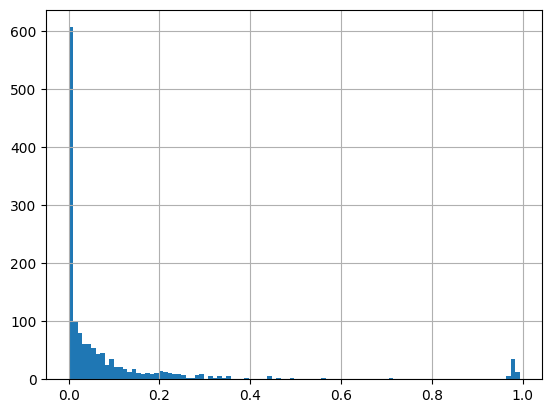

In [26]:
scores.map(lambda x: np.mean(np.sort(x)[::-1][:10])).hist(bins=100)

In [13]:
df_analysis = df_posts_train.copy()

df_analysis["full_text_en"] = df_posts_train_en["full_text"]
df_analysis["full_text_gs"] = df_posts_train["gs"].apply(lambda x: [df_fc.loc[y, "full_text"] for y in x])
df_analysis["entities_gs"] = df_posts_train["gs"].apply(lambda x: [df_fc.loc[y, "entities"] for y in x])
df_analysis["lemmas_gs"] = df_posts_train["gs"].apply(lambda x: [df_fc.loc[y, "lemmas"] for y in x])
df_analysis["entities_lemmas_gs"] = df_posts_train["gs"].apply(lambda x: [df_fc.loc[y, "entities_lemmas"] for y in x])



,full_text_en,full_text_gs,entities,entities_gs,lemmas,lemmas_gs,entities_lemmas,entities_lemmas_gs,max_len_entities_lemmas,max_len_entities,max_len_lemmas
post_id,,,,,,,,,,,
64,#curfew6:00 p.m.: the government plans to pay ...,"[covid-19: whistleblowers ""paid"" by the govern...",[curfew6:00],[[covid-19]],"[government, plan, pay, whistleblower, financi...","[[whistleblower, pay, government, parody, publ...","[curfew6:00, government, plan, pay, whistleblo...","[[covid-19, whistleblower, pay, government, pa...",4,0,0
79,* cold water closes 4 heart veins and causes a...,[drinking cold water is not harmful to the hea...,[4],[[]],"[cold, water, close, heart, vein, cause, heart...","[[drink, cold, water, harmful, heart, expert, ...","[4, cold, water, close, heart, vein, cause, he...","[[drink, cold, water, harmful, heart, expert, ...",7,1,0
86,*info alert from the ministry of health.* watc...,[the child in this photo was not poisoned by a...,"[the ministry of health, more than 50 tons, ye...",[[africa]],"[info, alert, ministry, health, watch, sugar, ...","[[child, photo, poison, adulterated, sugar, su...","[the ministry of health, more than 50 tons, ye...","[[africa, child, photo, poison, adulterated, s...",4,1,1
182,"2:24 p.m. as of march 1, 2021, the confinement...","[no, a lifting of anti-covid restrictions was ...","[2:24 p.m., march 1, 2021, canada, canada, mar...","[[march 1, canada, covid-19, canada, march 1]]","[march, confinement, covid, canada, date, mask...","[[lifting, anti, covid, restriction, plan, mar...","[2:24 p.m., march 1, 2021, canada, canada, mar...","[[march 1, canada, covid-19, canada, march 1, ...",8,2,1
192,15:15 : = all 5% france at stage 4 what france...,"[coronavirus: no, france will not go to stage ...","[15:15, 5%, france, today, monday 16 march, fr...","[[france, 4, monday march, france, march 16, 4]]","[france, stage, france, dread, finally, happen...","[[coronavirus, france, stage, monday, march, f...","[15:15, 5%, france, today, monday 16 march, fr...","[[france, 4, monday march, france, march 16, 4...",5,1,1
...,...,...,...,...,...,...,...,...,...,...,...
28017,the health pass is not necessary to give blood...,"[""unvaccinated can donate blood but can't go t...","[covid19, notaupassedelahonte, dictatorship]",[[covid-19]],"[health, pass, necessary, blood, appointment, ...","[[unvaccinated, donate, blood, restaurant, bew...","[covid19, notaupassedelahonte, dictatorship, h...","[[covid-19, unvaccinated, donate, blood, resta...",8,1,1
28018,the health pass is not necessary to give blood...,"[""unvaccinated can donate blood but can't go t...","[covid19, notaupassedelahonte, dictatorship]",[[covid-19]],"[health, pass, necessary, blood, appointment, ...","[[unvaccinated, donate, blood, restaurant, bew...","[covid19, notaupassedelahonte, dictatorship, h...","[[covid-19, unvaccinated, donate, blood, resta...",8,1,1
28024,a nurse hands this journalist instead - aureli...,[beware of the false statements of this nurse ...,"[22 27, 29, phew ]",[[]],"[nurse, hand, journalist, instead, aurelien, a...","[[beware, false, statement, nurse, compulsory,...","[22 27, 29, phew , nurse, hand, journalist, i...","[[beware, false, statement, nurse, compulsory,...",2,0,0


In [15]:
df_analysis_lemmas = df_analysis[df_analysis["max_len_lemmas"] == 0]
df_analysis_lemmas = df_analysis_lemmas[["full_text_en", "full_text_gs", "entities", "entities_gs", "lemmas", "lemmas_gs", "entities_lemmas", "entities_lemmas_gs", "max_len_entities_lemmas", "max_len_entities", "max_len_lemmas"]]
print(df_analysis_lemmas.head(10).to_markdown())

|   post_id | full_text_en                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | full_text_gs                             

In [12]:
df_posts_train[df_posts_train["max_len_entities"] == 0]

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,lemmas,...,max_len_entities_lemmas,idx_entities_lemmas,common_entities,len_common_entities,max_len_entities,idx_entities,common_lemmas,len_common_lemmas,max_len_lemmas,idx_lemmas
post_id,,,,,,,,,,,,,,,,,,,,,
64,#CouvreFeu18h00: Le gouvernement envisage de r...,,,fra,1,0,0,#couvrefeu18h00: le gouvernement envisage de r...,[40901],"[government, plan, pay, whistleblower, financi...",...,4,"[82612, 40901, 82598, 82654, 155839, 44372, 52...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
341,< Tweet francosenegalais38 a retweeté Didier R...,False information,,fra,1,0,0,< tweet francosenegalais38 a retweeté didier r...,[138011],"[tweet, retweete, didier, raoult, user, thank,...",...,6,"[138011, 136817, 137958, 153928, 138187, 43993...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
516,Avis IMPORTANT: si vous voyez ce genre de chos...,Partly false information,,fra,1,0,0,avis important: si vous voyez ce genre de chos...,[137152],"[important, notice, kind, thing, tick, nest, t...",...,4,"[137152, 44369, 137109, 108264, 138174, 79482,...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
590,CAB Il est très dangereux de couper un oignon ...,False information,,fra,1,0,0,cab il est très dangereux de couper un oignon ...,[137174],"[cab, dangerous, cut, onion, try, cook, day, d...",...,4,"[137174, 137926, 38902, 83561, 82671, 32191, 8...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
592,CABINET DE SOIN: LA SANTÉ GRÂCE AUX PLANTES & ...,False information,,fra,1,0,0,cabinet de soin: la santé grâce aux plantes & ...,[98005],"[treatment, practice, health, grace, plant, de...",...,3,"[82624, 44405, 82450, 138146, 83466, 137109, 8...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27534,,Partly false information,🔵🇨🇩Coup d’œil : la salle d'attente de l'aéropo...,fra,1,0,0,coup d’œil : la salle d'attente de l'aéroport...,[36626],"[glance, lodja, airport, waiting, room]",...,4,"[36626, 44388, 44245, 3941, 83548, 36709, 7945...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
27892,,False information,🛑ATTENTION À VOTRE CERVEAU🛑 ⚠La généticienne A...,fra,1,0,0,attention à votre cerveau la généticienne ale...,[83491],"[careful, brain, geneticist, alexandra, henrio...",...,5,"[95215, 42406, 155747, 83601, 83600, 83495, 44...","[[], [], [], [

In [26]:
df_posts_train.sort_values("len_lemmas", ascending=False).head(10)

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,lemmas,entities,len_lemmas,idx_lemmas
post_id,,,,,,,,,,,,,
25704,Post Share Urgent INFO depositphotos depositph...,False information,‪TRISTE RÉALITÉ : Intrigué par ce drame qui se...,fra,1,0,0,post share urgent info depositphotos depositph...,[83448],"[post, share, urgent, info, depositphotos, dep...","[haiti, haitian, jovenel moïse, the night of j...",6,"[83449, 136786, 83448, 82432, 28267, 80149, 82..."
8214,AIRFRANCE/ FOR AIR AUSTRAL,,Dates d'ouverture des aéroports du monde 🛩🛬🛫✈️...,fra,1,0,0,airfrance/ for air austral dates d'ouverture d...,[153558],"[air, austral, world, airport, opening, date, ...","[1, lebanon, july 15, 2020 2, june 10, 2020 3,...",5,"[82670, 101369, 52622, 36623, 138185, 80146, 1..."
347,= LUN. 1 8 15 22 1 8 FÉVR. 2021 MAR. MER. 2 3 ...,False information,,fra,1,0,0,= lun. 1 8 15 22 1 8 févr. 2021 mar. mer. 2 3 ...,[36156],"[mon, feb, tue, sea, game, fri, sit, sun, mont...","[mon., 22, 2 3, 10, 4 11, 5 12, 19, 26, 5 12, ...",5,"[36156, 52803, 155745, 81157, 44758, 36704, 26..."
8213,AIRFRANCE A AIR AUSTRAL CORSAR,False information,Dates d'ouverture des aéroports du monde 🛩🛬🛫✈️...,fra,1,0,0,airfrance a air austral corsar dates d'ouvertu...,[153558],"[airfrance, australia, corsar, world, airport,...","[australia, 1, djibouti, september 1, 2020 2, ...",5,"[82670, 101369, 52622, 36623, 138185, 80146, 4..."
13178,,False information.,La Chine produit en 4 HEURES autant de Co2 que...,fra,1,0,0,la chine produit en 4 heures autant de co2 qu...,[79805],"[china, produce, hour, switzerland, year, well...","[china, 4 hours, switzerland, 1 year, chinese,...",5,"[79805, 49406, 82794, 101369, 138205, 79806, 4..."
13067,NR PRESS Vladimir Poutine L'Afrique n'est qu'u...,False information.,"LE PRÉSIDENT RUSSE, #Vladimir #Poutine "" L’Afr...",fra,1,0,0,nr press vladimir poutine l'afrique n'est qu'u...,[108272],"[nr, press, vladimir, poutine, africa, cemeter...","[africa, one, african, russian, vladimir putin...",4,"[44758, 52622, 28267, 137137, 82432, 82433, 11..."
13068,NR PRESS Vladimir Poutine L'Afrique n'est qu'u...,False information.,"LE PRÉSIDENT RUSSE, Vladimir Poutine est #EST ...",fra,1,0,0,nr press vladimir poutine l'afrique n'est qu'u...,[108272],"[nr, press, vladimir, poutine, africa, cemeter...","[africa, one, african, russian, vladimir putin...",4,"[44758, 28267, 52622, 111174, 61171, 36575, 10..."
13069,NR PRESS Vladimir Poutine L'Afrique n'est qu'u...,False information.,"LE PRÉSIDENT RUSSE, Vladimir Poutine est #FÂCH...",fra,1,0,0,nr press vladimir poutine l'afrique n'est qu'u...,[108272],"[nr, press, vladimir, poutine, africa, cemeter...","[africa, one, african, russian, vladimir putin...",4,"[44758, 28267, 52622, 111174, 61171, 36575, 10..."
10440,,False information.,Faites-en ce que vous voulez! Message trop imp...,fra,1,0,0,faites-en ce que vous voulez! message trop im...,[4388],"[want, message, important, broadcast, planemia...","[two, third, covid-19, 19 1, 9, decades, janua...",4,"[44751, 30998, 52459, 137950, 82695, 79330, 83..."


In [2]:
from tqdm import tqdm
import numpy as np
tqdm.pandas()

d_pos_to_idx = dict(enumerate(df_fc.index))
apply_vec_map = np.vectorize(lambda x: d_pos_to_idx.get(x, -1), otypes=[int])
# df_posts_train["len_entities"] = df_posts_train["entities"].progress_apply(lambda x: apply_vec_map(np.argsort([len(set(x).intersection(fc_entities[i])) for i in range(len(fc_entities))])[::-1]))
df_posts_train["len_entities"] = df_posts_train["entities"].progress_apply(lambda x: np.sort([len(set(x).intersection(fc_entities[i])) for i in range(len(fc_entities))]))


KeyError: 'entities'

In [150]:
df_fc.loc[156184, "entities"]

['paris',
 'saudi arabia',
 '3.7 million',
 'the king of saudi arabia',
 '3.7 million',
 'paris']

In [151]:
df_posts_train

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,lemmas,entities,len_inter,len_entities
post_id,,,,,,,,,,,,,
64,#CouvreFeu18h00: Le gouvernement envisage de r...,,,fra,1,0,0,#couvrefeu18h00: le gouvernement envisage de r...,[40901],"[government, plan, pay, whistleblower, financi...",[curfew6:00],NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
79,* L'eau froide ferme 4 veines du cœur et provo...,False information,,fra,1,0,0,* l'eau froide ferme 4 veines du cœur et provo...,[80411],"[cold, water, close, heart, vein, cause, heart...",[4],NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
86,*ALERTE INFO DU MINISTERE DE LA SANTE.* Faites...,False information,,fra,1,0,0,*alerte info du ministere de la sante.* faites...,[136895],"[info, alert, ministry, health, watch, sugar, ...","[the ministry of health, more than 50 tons, ye...",NaN,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
182,"14 h 24 À compter du 1er mars 2021, le CONFINE...",False information,,fra,1,0,0,"14 h 24 à compter du 1er mars 2021, le confine...",[133424],"[march, confinement, covid, canada, date, mask...","[2:24 p.m., march 1, 2021, canada, canada, mar...",NaN,"[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
192,15:15 : = all 5% La FRANCE au STADE 4 Ce que l...,False information,,fra,1,0,0,15:15 : = all 5% la france au stade 4 ce que l...,[79930],"[france, stage, france, dread, finally, happen...","[15:15, 5%, france, today, monday 16 march, fr...",NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28017,LE PASS SANITAIRE N'EST PAS NÉCESSAIRE POUR DO...,Missing context,🤡🤥🤥🤥 Voici la preuve que le Covid19 est une es...,fra,1,0,0,le pass sanitaire n'est pas nécessaire pour do...,[82733],"[health, pass, necessary, blood, appointment, ...","[covid19, notaupassedelahonte, dictatorship]",NaN,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28018,LE PASS SANITAIRE N'EST PAS NÉCESSAIRE POUR DO...,Missing context,🤡🤥🤥🤥 Voici la preuve que le Covid19 est une es...,fra,1,0,0,le pass sanitaire n'est pas nécessaire pour do...,[82733],"[health, pass, necessary, blood, appointment, ...","[covid19, notaupassedelahonte, dictatorship]",NaN,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28024,Un infirmier remet ce journaliste à sa place -...,False information,🤣tien prend çà dans tes dents,fra,1,0,0,un infirmier remet ce journaliste à sa place -...,[137286],"[nurse, hand, journalist, instead, aurelien, a...","[22 27, 29, phew ]",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [119]:
df_fc.iloc[136895]["full_text"]

'the child in this photo was not poisoned by adulterated sugar but suffers from an oral infection due to the papillomavirus child suffers mouth sores from adulterated sugar sold in africa'

In [121]:
df_fc.loc[136895]["entities"]

['africa']

In [120]:
df_posts_train_en.loc[86]["full_text"]

'*info alert from the ministry of health.* watch out for sugar by powder you consume these this time. malicious people marketed *a deadly sugar whose composition exclusively chemical contains toxic products*. the source is discovered but more than 50 tons of this poison are already released on the market. (this information was broadcast on rfi yesterday at 10 a.m.). you can save a life by you too send this message to someone else '

In [123]:
df_posts_train.loc[86]["entities"]

['the ministry of health', 'more than 50 tons', 'yesterday', '10 a.m.']

In [118]:
df_posts_train.loc[86]["full_text"]

"*alerte info du ministere de la sante.* faites attention au sucre en poudre que vous consommez ces derniers temps-ci. des individus mal intentionnés ont mis sur le marché *un sucre mortel dont la composition exclusivement chimique contient des produits toxiques*. la source est découverte mais plus de 50 tonnes de ce poison sont déjà libérées sur le marché.(cette info est passée sur rfi hier à 10h). tu peux sauver une vie en envoyant toi aussi ce message à quelqu'un d'autre "

In [125]:
df_posts_train

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,lemmas,entities,len_inter,len_entities
post_id,,,,,,,,,,,,,
64,#CouvreFeu18h00: Le gouvernement envisage de r...,,,fra,1,0,0,#couvrefeu18h00: le gouvernement envisage de r...,[40901],"[government, plan, pay, whistleblower, financi...",[curfew6:00],NaN,[]
79,* L'eau froide ferme 4 veines du cœur et provo...,False information,,fra,1,0,0,* l'eau froide ferme 4 veines du cœur et provo...,[80411],"[cold, water, close, heart, vein, cause, heart...",[4],NaN,"[80, 204, 370, 371, 502, 813, 1239, 1745, 2466..."
86,*ALERTE INFO DU MINISTERE DE LA SANTE.* Faites...,False information,,fra,1,0,0,*alerte info du ministere de la sante.* faites...,[136895],"[info, alert, ministry, health, watch, sugar, ...","[the ministry of health, more than 50 tons, ye...",NaN,"[1310, 3010, 4197]"
182,"14 h 24 À compter du 1er mars 2021, le CONFINE...",False information,,fra,1,0,0,"14 h 24 à compter du 1er mars 2021, le confine...",[133424],"[march, confinement, covid, canada, date, mask...","[2:24 p.m., march 1, 2021, canada, canada, mar...",NaN,"[21, 58, 652, 850, 964, 1085, 1122, 1230, 1539..."
192,15:15 : = all 5% La FRANCE au STADE 4 Ce que l...,False information,,fra,1,0,0,15:15 : = all 5% la france au stade 4 ce que l...,[79930],"[france, stage, france, dread, finally, happen...","[15:15, 5%, france, today, monday 16 march, fr...",NaN,"[1, 4, 35, 44, 59, 88, 89, 98, 108, 118, 119, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28017,LE PASS SANITAIRE N'EST PAS NÉCESSAIRE POUR DO...,Missing context,🤡🤥🤥🤥 Voici la preuve que le Covid19 est une es...,fra,1,0,0,le pass sanitaire n'est pas nécessaire pour do...,[82733],"[health, pass, necessary, blood, appointment, ...","[covid19, notaupassedelahonte, dictatorship]",NaN,"[800, 1059, 1060, 1135, 3189]"
28018,LE PASS SANITAIRE N'EST PAS NÉCESSAIRE POUR DO...,Missing context,🤡🤥🤥🤥 Voici la preuve que le Covid19 est une es...,fra,1,0,0,le pass sanitaire n'est pas nécessaire pour do...,[82733],"[health, pass, necessary, blood, appointment, ...","[covid19, notaupassedelahonte, dictatorship]",NaN,"[800, 1059, 1060, 1135, 3189]"
28024,Un infirmier remet ce journaliste à sa place -...,False information,🤣tien prend çà dans tes dents,fra,1,0,0,un infirmier remet ce journaliste à sa place -...,[137286],"[nurse, hand, journalist, instead, aurelien, a...","[22 27, 29, phew ]",NaN,[]


In [2]:
# from transformers import pipeline
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# ner_model_path = "/gpfs/projects/bsc14/abecerr1/hub/models--FacebookAI--xlm-roberta-large-finetuned-conll03-english/snapshots/18f95e9924f3f452df09cc90945073906ef18f1e/"
# ner_tokenizer = AutoTokenizer.from_pretrained(ner_model_path)
# ner_model = AutoModelForTokenClassification.from_pretrained(ner_model_path)
# ner_classifier = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, device="cuda")
# ner_out = ner_classifier("Alya told Jasmine that Andrew could pay with cash..")

In [3]:
import spacy

spacy.prefer_gpu()
# nlp = spacy.load("xx_ent_wiki_sm")
nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm
import pandas as pd
tqdm.pandas()

df_posts_train = posts.df_train
# df_posts_train["entities"] = df_posts_train["full_text"].progress_apply(lambda x: nlp(x).ents)
df_posts_train["lemmas"] = df_posts_train["full_text"].progress_apply(lambda x: [y.lemma_ for y in nlp(x)])


100%|██████████| 4012/4012 [00:51<00:00, 77.80it/s]


In [9]:
df_posts_train["full_text"].iloc[:3].progress_apply(lambda x: [y.lemma_ for y in nlp(x)])

100%|██████████| 3/3 [00:00<00:00, 99.21it/s]


post_id
2     [", actually, ,, he, be, a, damn, sight, well,...
5     [", cigarette, smoking, do, not, cause, cancer...
13    [", environmentalist, ", Say, Fracking, be, ev...
Name: full_text, dtype: object

In [18]:
[y.lemma_ for y in nlp(df_posts_train["full_text"].iloc[0]) if y.is_stop == False and y.is_punct == False and y.is_space == False and y.pos_ in ["NOUN", "PROPN"]]

['sight',
 'president',
 'Miss',
 'Ardern',
 'Judith',
 'Collins',
 'Donald',
 'Trump',
 'thanks[SEP']

In [5]:
nlp("Alya told Jasmine that Andrew could pay with cash..").ents

(Jasmine, Andrew)

In [6]:
df_posts_train[df_posts_train["entities"].apply(lambda x: len(x) > 0)]

KeyError: 'entities'